In [70]:
import numpy as np
import xarray as xr

import datetime as dt
import os
import pandas as pd

import matplotlib.pyplot as plt

import altair as alt
alt.data_transformers.enable('json')

from sublimpy import utils
import glob
import pytz
import re
from scipy.signal import welch, csd
from scipy.stats import chi2
from process_fast_data.fast_data_calculate_spectra_nomrd import calculate_mrd_for_df, fast_data_files_to_dataframe
from sublimpy import extrautils

In [71]:
# DATA_DIR = "/storage/elilouis/sublimationofsnow/"
DATA_DIR = "/Users/elischwat/Development/data/sublimationofsnow/"

DATES = pd.Series(['20230418', '20230419'])
DATE_LOCAL = '20230418'

# DATES = pd.Series(['20230409', '20230410'])
# DATE_LOCAL = '20230409'

# TOOLS

## SAIL Data

In [72]:
class FastData(object):
    data = None

class FastDataSAIL(FastData):
    @staticmethod
    def open_raw(files):
        files = sorted(files)
        high_rate_dfs = []
        for file in files:
            # Regular expression. extract date
            date = re.search(r"gucecorM1\.00\.(\d+)\.", file).group(1)
            print(file)
            df = pd.read_csv(file, skiprows=1, header=None).rename(
                    columns = dict(
                        zip(range(0,10), 
                        [
                            'Timestamp',
                            'u',
                            'v',
                            'w',
                            'windspeed units (M = m/s)',
                            'Speed of Sound',
                            'Status (00 means okay)',
                            'CO2 analog voltage output',
                            'H20 analog voltage output',
                            'Checksum',
                        ])
                    )
                )
            df['time'] = pd.to_datetime(
                f'{date} ' + df['Timestamp'].str[:-3],
                format="%Y%m%d %H:%M:%S.%f"
            )
            high_rate_dfs.append(df)
        return pd.concat(high_rate_dfs).set_index('time')
    
    @staticmethod
    def double_rotation(df, u_col, v_col, w_col):
        # FIRST ROTATION
        mean_u = df[u_col].mean()
        mean_v = df[v_col].mean()
        theta = np.arctan2(mean_v, mean_u)
        adj_u = df[u_col]*np.cos(theta) + df[v_col]*np.sin(theta)
        adj_v = -df[u_col]*np.sin(theta) + df[v_col]*np.cos(theta)
        df[u_col] = adj_u
        df[v_col] = adj_v
        print(
            'Means after 1st rotation:',
            df[u_col].mean(),
            df[v_col].mean(),
            df[w_col].mean(),
        )

        # SECOND ROTATION
        mean_u = df[u_col].mean()
        mean_w = df[w_col].mean()
        phi = np.arctan2(mean_w, mean_u)
        adj_u = df[u_col]*np.cos(phi) + df[w_col]*np.sin(phi)
        adj_w = - df[u_col]*np.sin(phi) + df[w_col]*np.cos(phi)
        df[u_col] = adj_u
        df[w_col] = adj_w
        print(
            'Means after 2nd rotation:',
            df[u_col].mean(),
            df[v_col].mean(),
            df[w_col].mean(),
        )
        return df
    
    def apply_direction_rotation(df, u_col, v_col, w_col, bearing):
        # + Ugeo represents wind blowing to the East (confusingly known as a "westerly"). 
        # + Vgeo is wind to the North (a "southerly" ). This is right handed with respect to an upward +Wgeo.


        # FIRST ROTATION
        mean_u = df[u_col].mean()
        mean_v = df[v_col].mean()
        theta = np.arctan2(mean_v, mean_u)
        adj_u = df[u_col]*np.cos(theta) + df[v_col]*np.sin(theta)
        adj_v = -df[u_col]*np.sin(theta) + df[v_col]*np.cos(theta)
        df[u_col] = adj_u
        df[v_col] = adj_v
        print(
            'Means after 1st rotation:',
            df[u_col].mean(),
            df[v_col].mean(),
            df[w_col].mean(),
        )

# SAIL EC data

Open and wrangle the raw SAIL EC data

In [73]:
fast_data_files = DATES.apply(
    lambda date: glob.glob(
            os.path.join(
                DATA_DIR, 
                f"sail_fast_ecor_data/gucecorM1.00.{date}.000000.raw/**_sonic.raw"
            )
        )
).explode()
fast_data_files

0    /Users/elischwat/Development/data/sublimationo...
0    /Users/elischwat/Development/data/sublimationo...
0    /Users/elischwat/Development/data/sublimationo...
0    /Users/elischwat/Development/data/sublimationo...
0    /Users/elischwat/Development/data/sublimationo...
                           ...                        
1    /Users/elischwat/Development/data/sublimationo...
1    /Users/elischwat/Development/data/sublimationo...
1    /Users/elischwat/Development/data/sublimationo...
1    /Users/elischwat/Development/data/sublimationo...
1    /Users/elischwat/Development/data/sublimationo...
Length: 96, dtype: object

In [74]:
fast_df_sail = FastDataSAIL.open_raw(fast_data_files)
fast_df_sail = utils.modify_df_timezone(fast_df_sail.reset_index(), 'UTC', 'US/Mountain').set_index('time')
fast_df_sail = fast_df_sail.loc[DATE_LOCAL]
fast_df_sail = fast_df_sail.sort_index()

/Users/elischwat/Development/data/sublimationofsnow/sail_fast_ecor_data/gucecorM1.00.20230418.000000.raw/gucecorM1.00.20230418.000000.raw.2023_0417_2330_110_sonic.raw
/Users/elischwat/Development/data/sublimationofsnow/sail_fast_ecor_data/gucecorM1.00.20230418.000000.raw/gucecorM1.00.20230418.003000.raw.2023_0418_0000_110_sonic.raw
/Users/elischwat/Development/data/sublimationofsnow/sail_fast_ecor_data/gucecorM1.00.20230418.000000.raw/gucecorM1.00.20230418.010000.raw.2023_0418_0030_110_sonic.raw
/Users/elischwat/Development/data/sublimationofsnow/sail_fast_ecor_data/gucecorM1.00.20230418.000000.raw/gucecorM1.00.20230418.013000.raw.2023_0418_0100_110_sonic.raw
/Users/elischwat/Development/data/sublimationofsnow/sail_fast_ecor_data/gucecorM1.00.20230418.000000.raw/gucecorM1.00.20230418.020000.raw.2023_0418_0130_110_sonic.raw
/Users/elischwat/Development/data/sublimationofsnow/sail_fast_ecor_data/gucecorM1.00.20230418.000000.raw/gucecorM1.00.20230418.023000.raw.2023_0418_0200_110_sonic.ra

array([<Axes: xlabel='time'>, <Axes: xlabel='time'>,
       <Axes: xlabel='time'>], dtype=object)

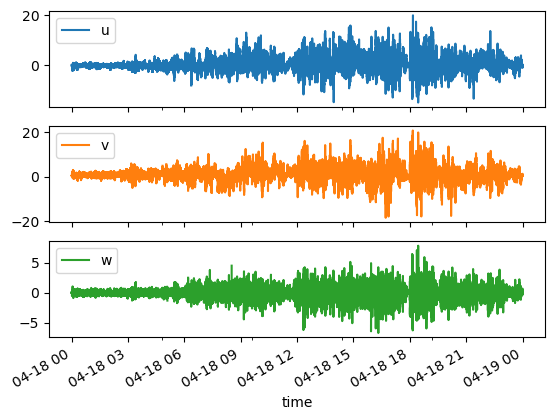

In [75]:
fast_df_sail[['u','v','w']].plot(subplots=True)

Calculate 30-minute mean u, v, w, and 30-min wind direction, plot it

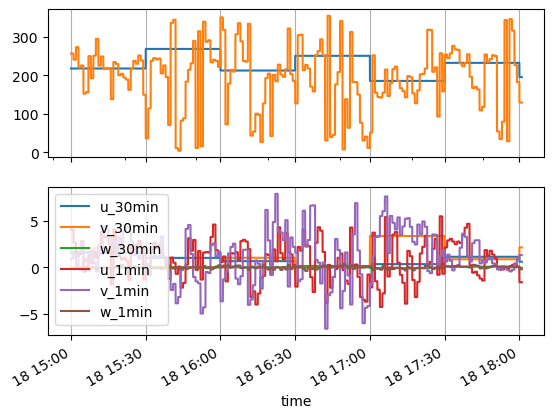

In [76]:
fast_df_sail = fast_df_sail.join(
    fast_df_sail.groupby(pd.Grouper(freq='30min'))[['u', 'v', 'w']].transform('mean').rename(columns = {
        'u': 'u_30min',
        'v': 'v_30min',
        'w': 'w_30min',
    })
)
fast_df_sail = fast_df_sail.join(
    fast_df_sail.groupby(pd.Grouper(freq='1min'))[['u', 'v', 'w']].transform('mean').rename(columns = {
        'u': 'u_1min',
        'v': 'v_1min',
        'w': 'w_1min',
    })
)
fast_df_sail['dir_30min'] = np.rad2deg(np.arctan2(-fast_df_sail['u_30min'], -fast_df_sail['v_30min']))
fast_df_sail['dir_30min'] = fast_df_sail['dir_30min'].apply(lambda dir: dir if dir >= 0 else dir+360)

fast_df_sail['dir_1min'] = np.rad2deg(np.arctan2(-fast_df_sail['u_1min'], -fast_df_sail['v_1min']))
fast_df_sail['dir_1min'] = fast_df_sail['dir_1min'].apply(lambda dir: dir if dir >= 0 else dir+360)

fig, axes = plt.subplots(2,1)
fast_df_sail['dir_30min'].loc[f'{DATE_LOCAL} 1500': f'{DATE_LOCAL} 1800'].plot(ax=axes[0], sharex=True)
fast_df_sail['dir_1min'].loc[f'{DATE_LOCAL} 1500': f'{DATE_LOCAL} 1800'].plot(ax=axes[0], sharex=True)
fast_df_sail[['u_30min','v_30min','w_30min']].loc[f'{DATE_LOCAL} 1500': f'{DATE_LOCAL} 1800'].plot(ax=axes[1])
fast_df_sail[['u_1min','v_1min','w_1min']].loc[f'{DATE_LOCAL} 1500': f'{DATE_LOCAL} 1800'].plot(ax=axes[1])
axes[0].grid(axis='x')  # Add grid lines only for the x-axis
axes[1].grid(axis='x')  # Add grid lines only for the x-axis
plt.show()

Apply double rotation to 30min chunks

In [77]:
fast_df_sail = fast_df_sail.groupby(pd.Grouper(freq='30min')).apply(lambda df: FastDataSAIL.double_rotation(df, 'u', 'v', 'w'))

Means after 1st rotation: 0.7581466693350655 -1.0244621171409705e-16 0.04991639549436796
Means after 2nd rotation: 0.7597881407096343 -1.0244621171409705e-16 6.4028882321310656e-18
Means after 1st rotation: 0.5479179296576053 -1.0159681655193568e-16 0.03076463360142985
Means after 2nd rotation: 0.5487809401946343 -1.0159681655193568e-16 3.571763081903989e-18
Means after 1st rotation: 0.6930997785466347 6.121410603145382e-18 0.06018899418479432
Means after 2nd rotation: 0.6957082851615116 6.121410603145382e-18 -3.251999382920984e-18
Means after 1st rotation: 0.5650753772153121 1.8244383928792558e-17 0.041837487964052636
Means after 2nd rotation: 0.5666220586371215 1.8244383928792558e-17 5.321278645897829e-18
Means after 1st rotation: 0.6573442622266382 2.4563676923592293e-17 0.04260681683141577
Means after 2nd rotation: 0.6587236293945959 2.4563676923592293e-17 0.0
Means after 1st rotation: 0.7476423027718858 -1.897415928594426e-17 0.05137858136300417
Means after 2nd rotation: 0.7494056

In [78]:
fast_df_sail.index = fast_df_sail.index.get_level_values(1)

In [79]:
fast_df_sail['u'] = fast_df_sail['u'].interpolate()
fast_df_sail['v'] = fast_df_sail['v'].interpolate()
fast_df_sail['w'] = fast_df_sail['w'].interpolate()

Calculate MRD

In [80]:
fast_df_sail

,Timestamp,u,v,w,windspeed units (M = m/s),Speed of Sound,Status (00 means okay),CO2 analog voltage output,H20 analog voltage output,Checksum,u_30min,v_30min,w_30min,u_1min,v_1min,w_1min,dir_30min,dir_1min
time,,,,,,,,,,,,,,,,,,
2023-04-18 00:00:00.010,06:00:00.01 Z,0.446200,-0.372968,0.000687,M,335.74,10,0.698450,1.196210,3B,-0.421934,0.538376,0.041909,-0.358383,0.570700,0.021067,141.913592,147.872350
2023-04-18 00:00:00.110,06:00:00.11 Z,0.442161,-0.394959,0.000953,M,335.89,0,0.698450,1.194990,3E,-0.421934,0.538376,0.041909,-0.358383,0.570700,0.021067,141.913592,147.872350
2023-04-18 00:00:00.210,06:00:00.21 Z,0.420874,-0.390911,0.012376,M,336.26,0,0.698145,1.196210,32,-0.421934,0.538376,0.041909,-0.358383,0.570700,0.021067,141.913592,147.872350
2023-04-18 00:00:00.310,06:00:00.31 Z,0.432883,-0.374937,0.011586,M,336.28,50,0.698145,1.194990,3A,-0.421934,0.538376,0.041909,-0.358383,0.570700,0.021067,141.913592,147.872350
2023-04-18 00:00:00.410,06:00:00.41 Z,0.458757,-0.406994,0.009882,M,335.54,10,0.698755,1.196515,36,-0.421934,0.538376,0.041909,-0.358383,0.570700,0.021067,141.913592,147.872350
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-04-18 23:59:59.490,05:59:59.49 Z,0.407389,-0.012298,0.027985,M,338.61,0,0.445300,1.052250,31,-0.434310,0.476267,-0.012072,-0.221636,0.837696,-0.010050,137.638195,165.180362
2023-04-18 23:59:59.600,05:59:59.60 Z,0.396505,0.021883,-0.002234,M,338.64,0,0.444690,1.051945,31,-0.434310,0.476267,-0.012072,-0.221636,0.837696,-0.010050,137.638195,165.180362
2023-04-18 23:59:59.690,05:59:59.69 Z,0.399288,-0.006176,0.037828,M,338.63,0,0.444690,1.052860,37,-0.434310,0.476267,-0.012072,-0.221636,0.837696,-0.010050,137.638195,165.180362


In [81]:
# mrd_uw_sail = fast_df_sail.groupby(pd.Grouper(freq='180min'))[['u', 'v', 'w']].apply(
#     lambda df: calculate_mrd_for_df(df.reset_index(), 'u', 'w', shift=2000, parallelism=20).assign(hour_group = f"{df.index.min()} - {df.index.max()}")
# )

mrd_uw_sail = calculate_mrd_for_df(
    fast_df_sail[['u', 'v', 'w']].reset_index(), 
    'u', 'w', 
    shift=1200, # 2 minute sliding window
    parallelism=20, 
    M=14, # 27.31 minute long calculations
)

Got data of length 922959. using M = 14
Timestep of fast data is: 100.0 ms
Dataset of length 922959, with M = 14, permits 755 iterations.


100%|██████████| 755/755 [00:35<00:00, 21.33it/s]


In [82]:
mrd_vw_sail = calculate_mrd_for_df(
    fast_df_sail[['u', 'v', 'w']].reset_index(), 
    'v', 'w', 
    shift=1200, # 2 minute sliding window
    parallelism=20, 
    M=14, # 27.31 minute long calculations
)

Got data of length 922959. using M = 14
Timestep of fast data is: 100.0 ms
Dataset of length 922959, with M = 14, permits 755 iterations.


100%|██████████| 755/755 [00:24<00:00, 30.46it/s]


In [83]:
mrd_uv_sail = calculate_mrd_for_df(
    fast_df_sail[['u', 'v', 'w']].reset_index(), 
    'u', 'v', 
    shift=1200, # 2 minute sliding window
    parallelism=20, 
    M=14, # 27.31 minute long calculations
)

Got data of length 922959. using M = 14
Timestep of fast data is: 100.0 ms
Dataset of length 922959, with M = 14, permits 755 iterations.


100%|██████████| 755/755 [00:24<00:00, 31.10it/s]


In [84]:
mrd_uu_sail = calculate_mrd_for_df(
    fast_df_sail[['u', 'v', 'w']].reset_index(), 
    'u', 'u', 
    shift=1200, # 2 minute sliding window
    parallelism=20, 
    M=14, # 27.31 minute long calculations
)
mrd_vv_sail = calculate_mrd_for_df(
    fast_df_sail[['u', 'v', 'w']].reset_index(), 
    'v', 'v', 
    shift=1200, # 2 minute sliding window
    parallelism=20, 
    M=14, # 27.31 minute long calculations
)
mrd_ww_sail = calculate_mrd_for_df(
    fast_df_sail[['u', 'v', 'w']].reset_index(), 
    'w', 'w', 
    shift=1200, # 2 minute sliding window
    parallelism=20, 
    M=14, # 27.31 minute long calculations
)

Got data of length 922959. using M = 14
Timestep of fast data is: 100.0 ms
Dataset of length 922959, with M = 14, permits 755 iterations.


100%|██████████| 755/755 [00:27<00:00, 27.56it/s]


Got data of length 922959. using M = 14
Timestep of fast data is: 100.0 ms
Dataset of length 922959, with M = 14, permits 755 iterations.


100%|██████████| 755/755 [00:25<00:00, 29.09it/s]


Got data of length 922959. using M = 14
Timestep of fast data is: 100.0 ms
Dataset of length 922959, with M = 14, permits 755 iterations.


100%|██████████| 755/755 [00:24<00:00, 31.00it/s]


# SPLASH EC data

In [85]:
splash_files = np.array([
    [f for f in glob.glob(
        os.path.join(DATA_DIR, "asfs/ASFS-50_Level2_SPLASH2021-2023/sledwind10hz.asfs50.level2.0.*.nc")
    ) if d in f]
    for d in DATES
]).flatten()
fast_df_splash = xr.open_mfdataset(splash_files).to_dataframe().rename(columns={
    'metek_u': 'u',
    'metek_v': 'v',
    'metek_w': 'w',
})

In [86]:
fast_df_splash = utils.modify_df_timezone(fast_df_splash.reset_index(), 'UTC', 'US/Mountain').set_index('time')
fast_df_splash = fast_df_splash.loc[DATE_LOCAL]

In [87]:
fast_df_splash = fast_df_splash.join(
    fast_df_splash.groupby(pd.Grouper(freq='30min'))[['u', 'v', 'w']].transform('mean').rename(columns = {
        'u': 'u_30min',
        'v': 'v_30min',
        'w': 'w_30min',
    })
)
fast_df_splash['dir_30min'] = np.rad2deg(np.arctan2(-fast_df_splash['u_30min'], -fast_df_splash['v_30min']))
fast_df_splash['dir_30min'] = fast_df_splash['dir_30min'].apply(lambda dir: dir if dir >= 0 else dir+360)

fast_df_splash = fast_df_splash.join(
    fast_df_splash.groupby(pd.Grouper(freq='1min'))[['u', 'v', 'w']].transform('mean').rename(columns = {
        'u': 'u_1min',
        'v': 'v_1min',
        'w': 'w_1min',
    })
)
fast_df_splash['dir_1min'] = np.rad2deg(np.arctan2(-fast_df_splash['u_1min'], -fast_df_splash['v_1min']))
fast_df_splash['dir_1min'] = fast_df_splash['dir_1min'].apply(lambda dir: dir if dir >= 0 else dir+360)

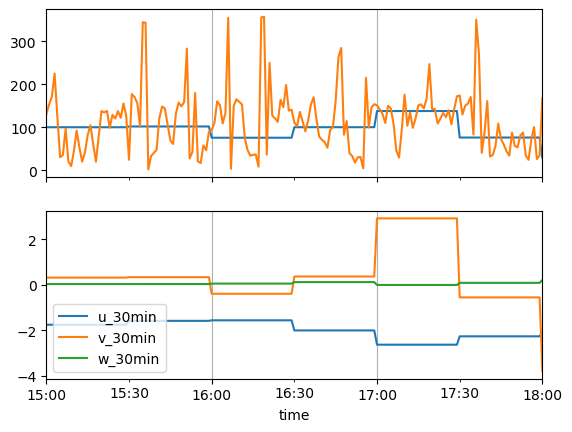

In [88]:
fast_df_splash_30min = fast_df_splash.groupby(pd.Grouper(freq='1min')).mean()
fig, axes = plt.subplots(2,1)
fast_df_splash_30min['dir_30min'].loc[f'{DATE_LOCAL} 1500': f'{DATE_LOCAL} 1800'].plot(ax=axes[0], sharex=True)
fast_df_splash_30min['dir_1min'].loc[f'{DATE_LOCAL} 1500': f'{DATE_LOCAL} 1800'].plot(ax=axes[0], sharex=True)
fast_df_splash_30min[['u_30min','v_30min','w_30min']].loc[f'{DATE_LOCAL} 1500': f'{DATE_LOCAL} 1800'].plot(ax=axes[1])
axes[0].grid(axis='x')  # Add grid lines only for the x-axis
axes[1].grid(axis='x')  # Add grid lines only for the x-axis
plt.show()

Apply double rotation to 3hr chunks

In [89]:
fast_df_splash = fast_df_splash.groupby(pd.Grouper(freq='30min')).apply(lambda df: FastDataSAIL.double_rotation(df, 'u', 'v', 'w'))

Means after 1st rotation: 1.4453233351593124 7.600234276653996e-17 0.09655929339887008
Means after 2nd rotation: 1.4485452151374936 7.600234276653996e-17 -5.838721644825336e-18
Means after 1st rotation: 1.1829558234644135 5.066822851102664e-17 0.06551564770952466
Means after 2nd rotation: 1.1847686611162396 5.066822851102664e-17 1.0489906683923485e-17
Means after 1st rotation: 1.434179636376986 5.0809759875582584e-17 0.10068992669065394
Means after 2nd rotation: 1.4377098771085193 5.0809759875582584e-17 -6.351219984447823e-18
Means after 1st rotation: 1.4139603148859217 4.908484637005706e-17 0.0615145163169062
Means after 2nd rotation: 1.4152977806066105 4.908484637005706e-17 -5.9376830286359346e-18
Means after 1st rotation: 1.3467967476919573 1.2033704271368828e-16 0.07486087550194172
Means after 2nd rotation: 1.348875691186757 1.2033704271368828e-16 -9.500292845817496e-18
Means after 1st rotation: 0.8760432042075951 -2.5404879937791292e-17 0.0644890801370074
Means after 2nd rotation:

In [90]:
fast_df_splash.index = fast_df_splash.index.get_level_values(1)

In [91]:
fast_df_splash['u'] = fast_df_splash['u'].interpolate()
fast_df_splash['v'] = fast_df_splash['v'].interpolate()
fast_df_splash['w'] = fast_df_splash['w'].interpolate()

Calculate MRD

In [92]:
mrd_uw_splash = calculate_mrd_for_df(
    fast_df_splash[['u', 'v', 'w']].reset_index(), 
    'u', 'w', 
    shift=1200, # 2 minute sliding window
    parallelism=20, 
    M=14, # 27.31 minute long calculations
)

Got data of length 864000. using M = 14
Timestep of fast data is: 100.0 ms
Dataset of length 864000, with M = 14, permits 706 iterations.


100%|██████████| 706/706 [00:29<00:00, 24.14it/s]


In [93]:
mrd_vw_splash = calculate_mrd_for_df(
    fast_df_splash[['u', 'v', 'w']].reset_index(), 
    'v', 'w', 
    shift=1200, # 2 minute sliding window
    parallelism=20, 
    M=14, # 27.31 minute long calculations
)

Got data of length 864000. using M = 14
Timestep of fast data is: 100.0 ms
Dataset of length 864000, with M = 14, permits 706 iterations.


100%|██████████| 706/706 [00:23<00:00, 29.98it/s]


In [94]:
mrd_uv_splash = calculate_mrd_for_df(
    fast_df_splash[['u', 'v', 'w']].reset_index(), 
    'u', 'v', 
    shift=1200, # 2 minute sliding window
    parallelism=20, 
    M=14, # 27.31 minute long calculations
)

Got data of length 864000. using M = 14
Timestep of fast data is: 100.0 ms
Dataset of length 864000, with M = 14, permits 706 iterations.


100%|██████████| 706/706 [00:22<00:00, 30.71it/s]


In [95]:
mrd_uu_splash = calculate_mrd_for_df(
    fast_df_splash[['u', 'v', 'w']].reset_index(), 
    'u', 'u', 
    shift=1200, # 2 minute sliding window
    parallelism=20, 
    M=14, # 27.31 minute long calculations
)
mrd_vv_splash = calculate_mrd_for_df(
    fast_df_splash[['u', 'v', 'w']].reset_index(), 
    'v', 'v', 
    shift=1200, # 2 minute sliding window
    parallelism=20, 
    M=14, # 27.31 minute long calculations
)
mrd_ww_splash = calculate_mrd_for_df(
    fast_df_splash[['u', 'v', 'w']].reset_index(), 
    'w', 'w', 
    shift=1200, # 2 minute sliding window
    parallelism=20, 
    M=14, # 27.31 minute long calculations
)

Got data of length 864000. using M = 14
Timestep of fast data is: 100.0 ms
Dataset of length 864000, with M = 14, permits 706 iterations.


100%|██████████| 706/706 [00:22<00:00, 30.71it/s]


Got data of length 864000. using M = 14
Timestep of fast data is: 100.0 ms
Dataset of length 864000, with M = 14, permits 706 iterations.


100%|██████████| 706/706 [00:29<00:00, 24.02it/s]


Got data of length 864000. using M = 14
Timestep of fast data is: 100.0 ms
Dataset of length 864000, with M = 14, permits 706 iterations.


100%|██████████| 706/706 [00:23<00:00, 29.92it/s]


# SOS EC data

Open data, average from 20hz to 10hz

In [96]:
sos_file_list = sorted(np.array([
    [f for f in glob.glob(
        os.path.join(DATA_DIR, "sosqc_fast/isfs_sos_qc_geo_tiltcor_hr_v2_**.nc")
    ) if d in f]
    for d in DATES
]).flatten())

In [97]:
fast_df_sos_all_data = fast_data_files_to_dataframe(
    sos_file_list,
    rotation='none'
)

In [98]:
fast_df_sos_all_data = utils.modify_df_timezone(fast_df_sos_all_data, 'UTC', 'US/Mountain')
fast_df_sos_all_data = fast_df_sos_all_data.set_index('time').loc[DATE_LOCAL]

In [99]:
fast_df_sos = fast_df_sos_all_data[['u_3m_c', 'v_3m_c', 'w_3m_c']].rename(columns={
    'u_3m_c': 'u',
    'v_3m_c': 'v',
    'w_3m_c': 'w',
})

resample the sos data from 20hz to 10hz with a simple block mean

In [100]:
fast_df_sos = fast_df_sos.resample('0.1s').mean()

In [101]:
fast_df_sos['dir'] = np.rad2deg(np.arctan2(-fast_df_sos['u'], -fast_df_sos['v']))

# Create 30min avgs
fast_df_sos = fast_df_sos.join(
    fast_df_sos.groupby(pd.Grouper(freq='30min'))[['u', 'v', 'w']].transform('mean').rename(columns = {
        'u': 'u_30min',
        'v': 'v_30min',
        'w': 'w_30min',
    })
)
fast_df_sos['dir_30min'] = np.rad2deg(np.arctan2(-fast_df_sos['u_30min'], -fast_df_sos['v_30min']))
fast_df_sos['dir_30min'] = fast_df_sos['dir_30min'].apply(lambda dir: dir if dir >= 0 else dir+360)

# Create 1min avgs
fast_df_sos = fast_df_sos.join(
    fast_df_sos.groupby(pd.Grouper(freq='1min'))[['u', 'v', 'w']].transform('mean').rename(columns = {
        'u': 'u_1min',
        'v': 'v_1min',
        'w': 'w_1min',
    })
)
fast_df_sos['dir_1min'] = np.rad2deg(np.arctan2(-fast_df_sos['u_1min'], -fast_df_sos['v_1min']))
fast_df_sos['dir_1min'] = fast_df_sos['dir_1min'].apply(lambda dir: dir if dir >= 0 else dir+360)

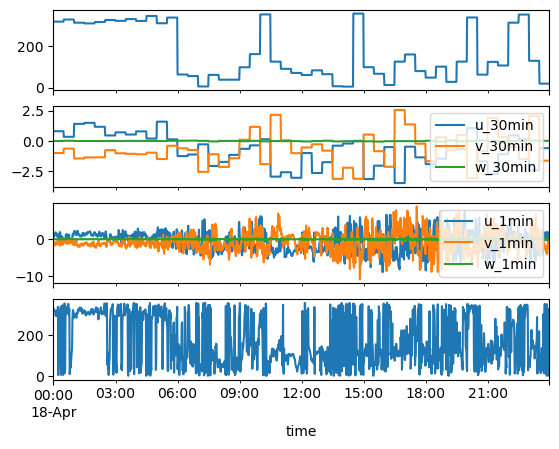

In [102]:
fast_df_sos_1min = fast_df_sos.groupby(pd.Grouper(freq='1min')).mean()
fig, axes = plt.subplots(4,1)
fast_df_sos_1min['dir_30min'].plot(ax=axes[0], sharex=True)
fast_df_sos_1min[['u_30min','v_30min','w_30min']].plot(ax=axes[1])
fast_df_sos_1min[['u_1min','v_1min','w_1min']].plot(ax=axes[2])
fast_df_sos_1min['dir_1min'].plot(ax=axes[3], sharex=True)
axes[0].grid(axis='x')  # Add grid lines only for the x-axis
axes[1].grid(axis='x')  # Add grid lines only for the x-axis
plt.show()

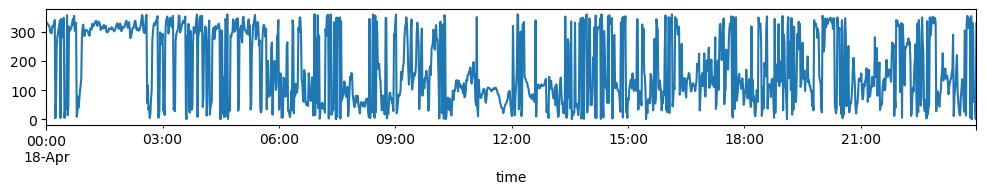

In [103]:
fast_df_sos_1min = fast_df_sos.groupby(pd.Grouper(freq='1min')).mean()
fig, axes = plt.subplots(figsize=(12,1.5))
fast_df_sos_1min['dir_1min'].plot(ax=axes, sharex=True)
plt.show()

Apply rotation into a given wind direction

In [104]:
# import numpy as np

# def project_winds(u, v):
#     # Convert -45 degrees to radians
#     angle = np.radians(-45)
#     print(angle)
#     # Define the rotation matrix
#     rotation_matrix = np.array([
#         [np.cos(angle), -np.sin(angle)],
#         [np.sin(angle), np.cos(angle)]
#     ])
#     print(rotation_matrix)
#     # Original wind vector
#     wind_vector = np.array([u, v])
#     print(wind_vector)
#     # Projected wind vector
#     projected_vector = rotation_matrix @ wind_vector
#     print(projected_vector)
#     return projected_vector

# # Example usage
# u = 10  # Westerly wind component
# v = 5   # Southerly wind component
# projected = project_winds(u, v)
# print("Projected winds:", projected)

In [105]:
# src = fast_df_sos.loc[f'{DATE_LOCAL} 1500': f'{DATE_LOCAL} 1501']
# u, v = project_winds(
#     src['u'],
#     src['v']
# )
# src['u_proj'] = u 
# src['v_proj'] = v
# src['dir_proj'] = np.rad2deg(np.arctan2(-src['u_proj'], -src['v_proj']))

In [106]:
# src[['u', 'v', 'dir']].plot(subplots=True)

In [107]:
# src[['u_proj', 'v_proj', 'dir_proj']].plot(subplots=True)

Apply double rotation to 3hr chunks

In [108]:
fast_df_sos = fast_df_sos.groupby(pd.Grouper(freq='30min')).apply(lambda df: FastDataSAIL.double_rotation(df, 'u', 'v', 'w'))

Means after 1st rotation: 1.2836255 4.7471787e-08 0.0009006463
Means after 2nd rotation: 1.2836258 4.7471787e-08 6.8876477e-10
Means after 1st rotation: 0.71807766 0.0 0.025522856
Means after 2nd rotation: 0.7185311 0.0 -5.298191e-10
Means after 1st rotation: 2.0253246 5.4253473e-08 0.0023221856
Means after 2nd rotation: 2.0253263 5.4253473e-08 -1.05963814e-10
Means after 1st rotation: 2.027811 4.3233236e-08 0.0038968676
Means after 2nd rotation: 2.0278146 4.3233236e-08 8.477105e-10
Means after 1st rotation: 1.7913774 1.0172526e-07 0.006320951
Means after 2nd rotation: 1.7913885 1.0172526e-07 1.0066562e-09
Means after 1st rotation: 0.8838117 -6.781684e-09 0.005982199
Means after 2nd rotation: 0.88383204 -6.781684e-09 0.0
Means after 1st rotation: 1.2406425 -7.4598525e-08 0.0024595934
Means after 2nd rotation: 1.2406449 -7.4598525e-08 2.1192763e-10
Means after 1st rotation: 1.1853908 -7.6293944e-08 0.014954861
Means after 2nd rotation: 1.1854852 -7.6293944e-08 -2.9404958e-09
Means after

In [109]:
fast_df_sos.index = fast_df_sos.index.get_level_values(1)

In [110]:
fast_df_sos['u'] = fast_df_sos['u'].interpolate()
fast_df_sos['v'] = fast_df_sos['v'].interpolate()
fast_df_sos['w'] = fast_df_sos['w'].interpolate()

Calculate TKE

In [111]:
fast_df_sos['tke'] = 0.5 * ( fast_df_sos['u']**2 + fast_df_sos['v']**2 + fast_df_sos['w']**2 ) 

Calculate MRD

In [112]:
mrd_uw_sos = calculate_mrd_for_df(
    fast_df_sos[['u', 'v', 'w']].reset_index(), 
    'u', 'w', 
    shift=1200, # 2 minute sliding window
    parallelism=20, 
    M=14, # 27.31 minute long calculations
)

Got data of length 864000. using M = 14
Timestep of fast data is: 100.0 ms
Dataset of length 864000, with M = 14, permits 706 iterations.


100%|██████████| 706/706 [00:32<00:00, 21.63it/s]


In [113]:
mrd_vw_sos = calculate_mrd_for_df(
    fast_df_sos[['u', 'v', 'w']].reset_index(), 
    'v', 'w', 
    shift=1200, # 2 minute sliding window
    parallelism=20, 
    M=14, # 27.31 minute long calculations
)

Got data of length 864000. using M = 14
Timestep of fast data is: 100.0 ms
Dataset of length 864000, with M = 14, permits 706 iterations.


100%|██████████| 706/706 [00:32<00:00, 21.90it/s]


In [114]:
mrd_uv_sos = calculate_mrd_for_df(
    fast_df_sos[['u', 'v', 'w']].reset_index(), 
    'u', 'v', 
    shift=1200, # 2 minute sliding window
    parallelism=20, 
    M=14, # 27.31 minute long calculations
)

Got data of length 864000. using M = 14
Timestep of fast data is: 100.0 ms
Dataset of length 864000, with M = 14, permits 706 iterations.


100%|██████████| 706/706 [00:39<00:00, 18.04it/s]


In [115]:
mrd_ww_sos = calculate_mrd_for_df(
    fast_df_sos[['u', 'v', 'w']].reset_index(), 
    'w', 'w', 
    shift=1200, # 2 minute sliding window
    parallelism=20, 
    M=14, # 27.31 minute long calculations
)
mrd_uu_sos = calculate_mrd_for_df(
    fast_df_sos[['u', 'v', 'w']].reset_index(), 
    'u', 'u', 
    shift=1200, # 2 minute sliding window
    parallelism=20, 
    M=14, # 27.31 minute long calculations
)
mrd_vv_sos = calculate_mrd_for_df(
    fast_df_sos[['u', 'v', 'w']].reset_index(), 
    'v', 'v', 
    shift=1200, # 2 minute sliding window
    parallelism=20, 
    M=14, # 27.31 minute long calculations
)

Got data of length 864000. using M = 14
Timestep of fast data is: 100.0 ms
Dataset of length 864000, with M = 14, permits 706 iterations.


100%|██████████| 706/706 [00:32<00:00, 21.79it/s]


Got data of length 864000. using M = 14
Timestep of fast data is: 100.0 ms
Dataset of length 864000, with M = 14, permits 706 iterations.


100%|██████████| 706/706 [00:34<00:00, 20.34it/s]


Got data of length 864000. using M = 14
Timestep of fast data is: 100.0 ms
Dataset of length 864000, with M = 14, permits 706 iterations.


100%|██████████| 706/706 [00:34<00:00, 20.68it/s]


In [116]:
date1 = "2023-04-09 18:00"
date2 = "2023-04-09 19:00"
src_0409 = pd.concat([
    mrd_uu_sos[ (mrd_uu_sos.start_time > date1) & (mrd_uu_sos.end_time < date2)].assign(site='sos').assign(stress='uu'),
    mrd_uu_sail[ (mrd_uu_sail.start_time > date1) & (mrd_uu_sail.end_time < date2)].assign(site='sail').assign(stress='uu'),
    mrd_uu_splash[ (mrd_uu_splash.start_time > date1) & (mrd_uu_splash.end_time < date2)].assign(site='splash').assign(stress='uu'),

    mrd_vv_sos[ (mrd_vv_sos.start_time > date1) & (mrd_vv_sos.end_time < date2)].assign(site='sos').assign(stress='vv'),
    mrd_vv_sail[ (mrd_vv_sail.start_time > date1) & (mrd_vv_sail.end_time < date2)].assign(site='sail').assign(stress='vv'),
    mrd_vv_splash[ (mrd_vv_splash.start_time > date1) & (mrd_vv_splash.end_time < date2)].assign(site='splash').assign(stress='vv'),

    mrd_ww_sos[ (mrd_ww_sos.start_time > date1) & (mrd_ww_sos.end_time < date2)].assign(site='sos').assign(stress='ww'),
    mrd_ww_sail[ (mrd_ww_sail.start_time > date1) & (mrd_ww_sail.end_time < date2)].assign(site='sail').assign(stress='ww'),
    mrd_ww_splash[ (mrd_ww_splash.start_time > date1) & (mrd_ww_splash.end_time < date2)].assign(site='splash').assign(stress='ww'),

    mrd_uw_sos[ (mrd_uw_sos.start_time > date1) & (mrd_uw_sos.end_time < date2)].assign(site='sos').assign(stress='uw'),
    mrd_uw_sail[ (mrd_uw_sail.start_time > date1) & (mrd_uw_sail.end_time < date2)].assign(site='sail').assign(stress='uw'),
    mrd_uw_splash[ (mrd_uw_splash.start_time > date1) & (mrd_uw_splash.end_time < date2)].assign(site='splash').assign(stress='uw'),

    mrd_vw_sos[ (mrd_vw_sos.start_time > date1) & (mrd_vw_sos.end_time < date2)].assign(site='sos').assign(stress='vw'),
    mrd_vw_sail[ (mrd_vw_sail.start_time > date1) & (mrd_vw_sail.end_time < date2)].assign(site='sail').assign(stress='vw'),
    mrd_vw_splash[ (mrd_vw_splash.start_time > date1) & (mrd_vw_splash.end_time < date2)].assign(site='splash').assign(stress='vw'),
    
    mrd_uv_sos[ (mrd_uv_sos.start_time > date1) & (mrd_uv_sos.end_time < date2)].assign(site='sos').assign(stress='uv'),
    mrd_uv_sail[ (mrd_uv_sail.start_time > date1) & (mrd_uv_sail.end_time < date2)].assign(site='sail').assign(stress='uv'),
    mrd_uv_splash[ (mrd_uv_splash.start_time > date1) & (mrd_uv_splash.end_time < date2)].assign(site='splash').assign(stress='uv'),
])
alt.Chart(src_0409).mark_line().encode(
    alt.X('tau:Q').scale(reverse=True, type='log'),
    alt.Y('mean(Co)').scale(type='symlog'),
    alt.Color('site:N'),
    alt.Facet('stress:O', columns=3).sort(['uu', 'vv', 'ww', 'uw', 'vw', 'uv']),
).properties(width=150, height=100).resolve_scale(y='independent')

alt.Chart(...)

In [117]:
date1 = "2023-04-18 18:00"
date2 = "2023-04-18 19:00"
src_0418 = pd.concat([
    mrd_uu_sos[ (mrd_uu_sos.start_time > date1) & (mrd_uu_sos.end_time < date2)].assign(site='sos').assign(stress='uu'),
    mrd_uu_sail[ (mrd_uu_sail.start_time > date1) & (mrd_uu_sail.end_time < date2)].assign(site='sail').assign(stress='uu'),
    mrd_uu_splash[ (mrd_uu_splash.start_time > date1) & (mrd_uu_splash.end_time < date2)].assign(site='splash').assign(stress='uu'),

    mrd_vv_sos[ (mrd_vv_sos.start_time > date1) & (mrd_vv_sos.end_time < date2)].assign(site='sos').assign(stress='vv'),
    mrd_vv_sail[ (mrd_vv_sail.start_time > date1) & (mrd_vv_sail.end_time < date2)].assign(site='sail').assign(stress='vv'),
    mrd_vv_splash[ (mrd_vv_splash.start_time > date1) & (mrd_vv_splash.end_time < date2)].assign(site='splash').assign(stress='vv'),

    mrd_ww_sos[ (mrd_ww_sos.start_time > date1) & (mrd_ww_sos.end_time < date2)].assign(site='sos').assign(stress='ww'),
    mrd_ww_sail[ (mrd_ww_sail.start_time > date1) & (mrd_ww_sail.end_time < date2)].assign(site='sail').assign(stress='ww'),
    mrd_ww_splash[ (mrd_ww_splash.start_time > date1) & (mrd_ww_splash.end_time < date2)].assign(site='splash').assign(stress='ww'),

    mrd_uw_sos[ (mrd_uw_sos.start_time > date1) & (mrd_uw_sos.end_time < date2)].assign(site='sos').assign(stress='uw'),
    mrd_uw_sail[ (mrd_uw_sail.start_time > date1) & (mrd_uw_sail.end_time < date2)].assign(site='sail').assign(stress='uw'),
    mrd_uw_splash[ (mrd_uw_splash.start_time > date1) & (mrd_uw_splash.end_time < date2)].assign(site='splash').assign(stress='uw'),

    mrd_vw_sos[ (mrd_vw_sos.start_time > date1) & (mrd_vw_sos.end_time < date2)].assign(site='sos').assign(stress='vw'),
    mrd_vw_sail[ (mrd_vw_sail.start_time > date1) & (mrd_vw_sail.end_time < date2)].assign(site='sail').assign(stress='vw'),
    mrd_vw_splash[ (mrd_vw_splash.start_time > date1) & (mrd_vw_splash.end_time < date2)].assign(site='splash').assign(stress='vw'),
    
    mrd_uv_sos[ (mrd_uv_sos.start_time > date1) & (mrd_uv_sos.end_time < date2)].assign(site='sos').assign(stress='uv'),
    mrd_uv_sail[ (mrd_uv_sail.start_time > date1) & (mrd_uv_sail.end_time < date2)].assign(site='sail').assign(stress='uv'),
    mrd_uv_splash[ (mrd_uv_splash.start_time > date1) & (mrd_uv_splash.end_time < date2)].assign(site='splash').assign(stress='uv'),
])
alt.Chart(src).mark_line().encode(
    alt.X('tau:Q').scale(reverse=True, type='log'),
    alt.Y('mean(Co)').scale(type='symlog'),
    alt.Color('site:N'),
    alt.Facet('stress:O', columns=3).sort(['uu', 'vv', 'ww', 'uw', 'vw', 'uv']),
).properties(width=150, height=100).resolve_scale(y='independent')

alt.Chart(...)

Text(0, 0.5, "$Co(\\overline{w'w'})$")

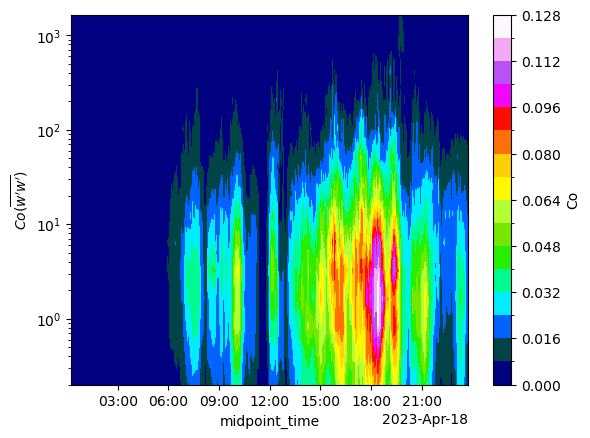

In [118]:
# AVP
src = mrd_ww_sos.copy()
src['midpoint_time'] = src['start_time'] + (src['end_time'] - src['start_time']) / 2
src = src.reset_index()
ds = src.set_index(['midpoint_time', 'tau']).to_xarray()
ds['Co'].plot.contourf(x='midpoint_time', y='tau', cmap='gist_ncar', levels=21)
plt.yscale('log')
plt.ylabel(r"$Co(\overline{w'w'})$")

# Plot three sites comparison plot

## $\overline{u'w'}$

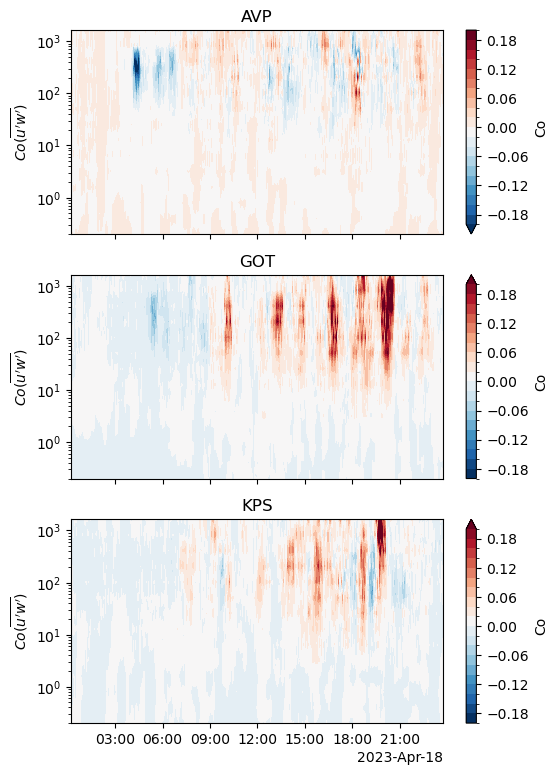

In [119]:
fig, axes = plt.subplots(3,1, figsize=(6,9), sharex=True, sharey=True)

# AVP
src = mrd_uw_splash.copy()
src['midpoint_time'] = src['start_time'] + (src['end_time'] - src['start_time']) / 2
src = src.reset_index()
ds = src.set_index(['midpoint_time', 'tau']).to_xarray()
ds['Co'].plot.contourf(x='midpoint_time', y='tau', cmap='RdBu_r', levels=21, vmin=-0.2, vmax=0.2, ax=axes[0])
axes[0].set_title('AVP')

# GOT
src = mrd_uw_sail.copy()
src['midpoint_time'] = src['start_time'] + (src['end_time'] - src['start_time']) / 2
src = src.reset_index()
ds = src.set_index(['midpoint_time', 'tau']).to_xarray()
ds['Co'].plot.contourf(x='midpoint_time', y='tau', cmap='RdBu_r', levels=21, vmin=-0.2, vmax=0.2, ax=axes[1])
axes[1].set_title('GOT')

# KPS
src = mrd_uw_sos.copy()
src['midpoint_time'] = src['start_time'] + (src['end_time'] - src['start_time']) / 2
src = src.reset_index()
ds = src.set_index(['midpoint_time', 'tau']).to_xarray()
ds['Co'].plot.contourf(x='midpoint_time', y='tau', cmap='RdBu_r', levels=21, vmin=-0.2, vmax=0.2, ax=axes[2])
axes[2].set_title('KPS')
for ax in axes:
    ax.set_yscale('log')
    ax.set_xlabel('')
    ax.set_ylabel(r"$Co(\overline{u'w'})$")

## $\overline{v'w'}$

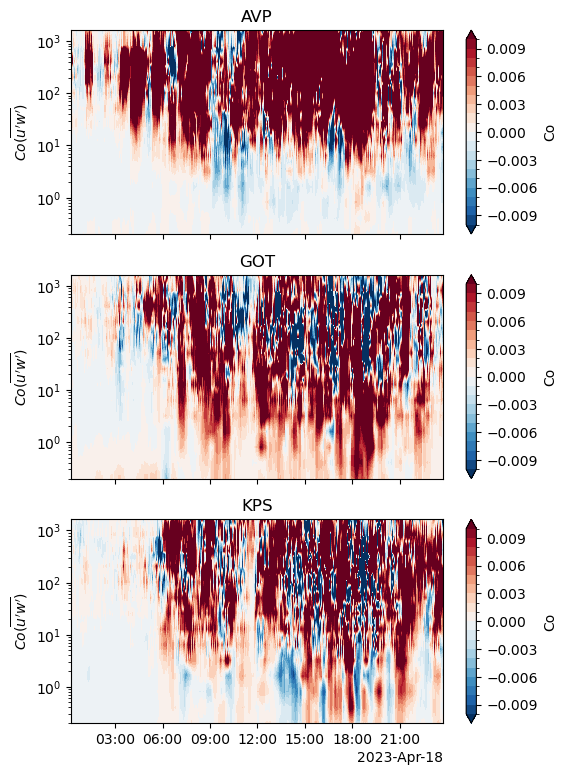

In [120]:
fig, axes = plt.subplots(3,1, figsize=(6,9), sharex=True, sharey=True)

# AVP
src = mrd_vw_splash.copy()
src['midpoint_time'] = src['start_time'] + (src['end_time'] - src['start_time']) / 2
src = src.reset_index()
ds = src.set_index(['midpoint_time', 'tau']).to_xarray()
ds['Co'].plot.contourf(x='midpoint_time', y='tau', cmap='RdBu_r', levels=21, vmin=-0.01, vmax=0.01, ax=axes[0])
axes[0].set_title('AVP')

# GOT
src = mrd_vw_sail.copy()
src['midpoint_time'] = src['start_time'] + (src['end_time'] - src['start_time']) / 2
src = src.reset_index()
ds = src.set_index(['midpoint_time', 'tau']).to_xarray()
ds['Co'].plot.contourf(x='midpoint_time', y='tau', cmap='RdBu_r', levels=21, vmin=-0.01, vmax=0.01, ax=axes[1])
axes[1].set_title('GOT')

# KPS
src = mrd_vw_sos.copy()
src['midpoint_time'] = src['start_time'] + (src['end_time'] - src['start_time']) / 2
src = src.reset_index()
ds = src.set_index(['midpoint_time', 'tau']).to_xarray()
ds['Co'].plot.contourf(x='midpoint_time', y='tau', cmap='RdBu_r', levels=21, vmin=-0.01, vmax=0.01, ax=axes[2])
axes[2].set_title('KPS')
for ax in axes:
    ax.set_yscale('log')
    ax.set_xlabel('')
    ax.set_ylabel(r"$Co(\overline{u'w'})$")

## $\overline{u'v'}$

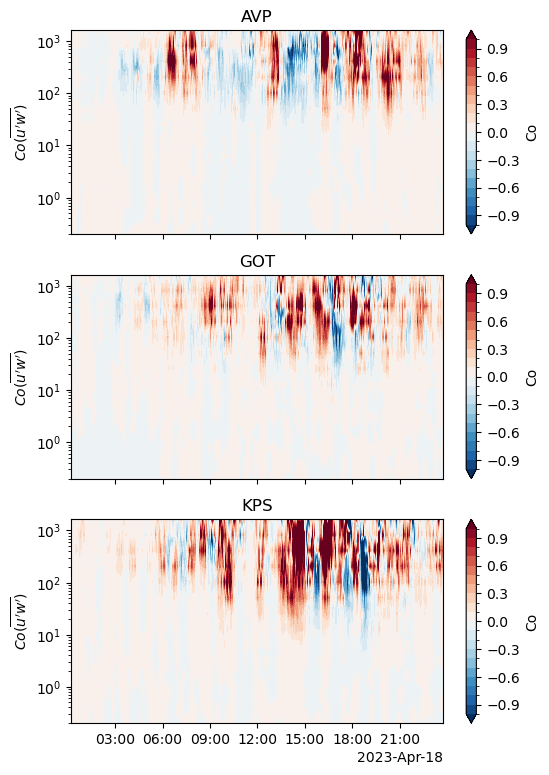

In [121]:
fig, axes = plt.subplots(3,1, figsize=(6,9), sharex=True, sharey=True)

# AVP
src = mrd_uv_splash.copy()
src['midpoint_time'] = src['start_time'] + (src['end_time'] - src['start_time']) / 2
src = src.reset_index()
ds = src.set_index(['midpoint_time', 'tau']).to_xarray()
ds['Co'].plot.contourf(x='midpoint_time', y='tau', cmap='RdBu_r', levels=21, vmin=-1, vmax=1, ax=axes[0])
axes[0].set_title('AVP')

# GOT
src = mrd_uv_sail.copy()
src['midpoint_time'] = src['start_time'] + (src['end_time'] - src['start_time']) / 2
src = src.reset_index()
ds = src.set_index(['midpoint_time', 'tau']).to_xarray()
ds['Co'].plot.contourf(x='midpoint_time', y='tau', cmap='RdBu_r', levels=21, vmin=-1, vmax=1, ax=axes[1])
axes[1].set_title('GOT')

# KPS
src = mrd_uv_sos.copy()
src['midpoint_time'] = src['start_time'] + (src['end_time'] - src['start_time']) / 2
src = src.reset_index()
ds = src.set_index(['midpoint_time', 'tau']).to_xarray()
ds['Co'].plot.contourf(x='midpoint_time', y='tau', cmap='RdBu_r', levels=21, vmin=-1, vmax=1, ax=axes[2])
axes[2].set_title('KPS')
for ax in axes:
    ax.set_yscale('log')
    ax.set_xlabel('')
    ax.set_ylabel(r"$Co(\overline{u'w'})$")

In [122]:
src_uv = pd.concat([
    mrd_uv_splash[(mrd_uv_splash.start_time > '20230418 1500') & (mrd_uv_splash.start_time < '20230418 1700')].assign(
        site = 'splash'
    ),
    mrd_uv_sail[(mrd_uv_sail.start_time > '20230418 1500') & (mrd_uv_sail.start_time < '20230418 1700')].assign(
        site = 'sail'
    ),
    mrd_uv_sos[(mrd_uv_sos.start_time > '20230418 1500') & (mrd_uv_sos.start_time < '20230418 1700')].assign(
        site ='sos' 
    ),
])

In [123]:
horizontal_line = alt.Chart().mark_rule(color='red').encode(y=alt.datum(0))

(
    horizontal_line + alt.Chart(
        src.reset_index()
    ).mark_boxplot(
        opacity=0.5
    ).encode(
        alt.X('tau:Q').scale(type='log'),
        alt.Y('Co:Q'),
        alt.Color('site:N')
    )
).configure_axis(grid=False)

alt.LayerChart(...)

In [66]:
alt.Chart(
    mrd_uw_splash.set_index('start_time').loc[f'{DATE_LOCAL} 1200': f'{DATE_LOCAL} 1600']
).mark_line().encode(
    alt.X('tau:Q').scale(type='log'),
    alt.Y('median(Co):Q'),
) + alt.Chart(
    mrd_uw_sail.set_index('start_time').loc[f'{DATE_LOCAL} 1200': f'{DATE_LOCAL} 1600']
).mark_line().encode(
    alt.X('tau:Q').scale(type='log'),
    alt.Y('median(Co):Q'),
) + alt.Chart(
    mrd_uw_sos.set_index('start_time').loc[f'{DATE_LOCAL} 1200': f'{DATE_LOCAL} 1600']
).mark_line().encode(
    alt.X('tau:Q').scale(type='log'),
    alt.Y('median(Co):Q'),
)

alt.LayerChart(...)

In [ ]:
mrd_uu_sos = fast_df_sos.groupby(pd.Grouper(freq='180min'))[['u', 'v', 'w']].apply(
    lambda df: calculate_mrd_for_df(df.reset_index(), 'u', 'u', shift=2000, parallelism=20).assign(hour_group = f"{df.index.min()} - {df.index.max()}")
)
mrd_vv_sos = fast_df_sos.groupby(pd.Grouper(freq='180min'))[['u', 'v', 'w']].apply(
    lambda df: calculate_mrd_for_df(df.reset_index(), 'v', 'v', shift=2000, parallelism=20).assign(hour_group = f"{df.index.min()} - {df.index.max()}")
)
mrd_ww_sos = fast_df_sos.groupby(pd.Grouper(freq='180min'))[['u', 'v', 'w']].apply(
    lambda df: calculate_mrd_for_df(df.reset_index(), 'w', 'w', shift=2000, parallelism=20).assign(hour_group = f"{df.index.min()} - {df.index.max()}")
)

mrd_wtke_sos = fast_df_sos.groupby(pd.Grouper(freq='180min'))[['u', 'v', 'w', 'tke']].apply(
    lambda df: calculate_mrd_for_df(df.reset_index(), 'w', 'tke', shift=2000, parallelism=20).assign(hour_group = f"{df.index.min()} - {df.index.max()}")
)

In [ ]:
mrd_wtke_sos = calculate_mrd_for_df(fast_df_sos.reset_index(), 'w', 'tke', M=15, shift=1200, parallelism=20)

In [ ]:
src = mrd_wtke_sos.copy()
src['midpoint_time'] = src['start_time'] + (src['end_time'] - src['start_time']) / 2
src = src[src.start_time.dt.hour >= 12]
src = src.reset_index()
ds = src.set_index(['midpoint_time', 'tau']).to_xarray()
ds['Co'].plot.contourf(x='midpoint_time', y='tau', cmap='PuOr', levels=20, figsize=(10,4))
plt.yscale('log')

In [ ]:
alt.Chart(
    mrd_uu_sos.reset_index()
).mark_line().encode(
    alt.X('tau:Q').scale(type='log'),
    alt.Y('mean(Co):Q'),
    alt.Color('hour_group:O').scale(scheme='purpleorange'),
).properties(width=200, height=200, title='3m uu') | alt.Chart(
    mrd_vv_sos.reset_index()
).mark_line().encode(
    alt.X('tau:Q').scale(type='log'),
    alt.Y('mean(Co):Q'),
    alt.Color('hour_group:O').scale(scheme='purpleorange'),
).properties(width=200, height=200, title='3m vv') | alt.Chart(
    mrd_ww_sos.reset_index()
).mark_line().encode(
    alt.X('tau:Q').scale(type='log'),
    alt.Y('mean(Co):Q'),
    alt.Color('hour_group:O').scale(scheme='purpleorange'),
).properties(width=200, height=200, title='3m ww')

In [ ]:
mrd_uw_sos = fast_df_sos.groupby(pd.Grouper(freq='180min'))[['u', 'v', 'w']].apply(
    lambda df: calculate_mrd_for_df(df.reset_index(), 'u', 'w', shift=2000, parallelism=20).assign(hour_group = f"{df.index.min()} - {df.index.max()}")
)

In [ ]:
mrd_uw_sos.hour_group = mrd_uw_sos.hour_group.str.replace('2023-04-09 ', '')

In [ ]:
daily_mrd_sos_chart = alt.Chart(
    mrd_uw_sos.reset_index()
).mark_line().encode(
    alt.X('tau:Q').scale(type='log'),
    alt.Y('mean(Co):Q').scale(domain = [-0.1, 0.05]),
    alt.Color('hour_group:O'),
).properties(width=200, height=200, title='sos')
daily_mrd_sos_chart

In [ ]:
mrd_uw_sos['time_range'] = mrd_uw_sos.apply(
    lambda row: str(row['start_time'].time()) + ' - ' + str(row['end_time'].time()),
    axis=1
)

In [ ]:
mrd_uw_sos.hour_group.unique()

In [ ]:
src = mrd_uw_sos.query("""
        hour_group == '2023-04-18 15:00:00 - 2023-04-18 17:59:59.950000'
    """).reset_index()
alt.Chart(
    src.reset_index()
).mark_line().encode(
    alt.X('tau:Q').scale(type='log'),
    alt.Y('Co:Q'),
    alt.Color('time_range:O').scale(scheme='purpleorange'),
).properties(width=500, height=500, title='sos')

In [ ]:
src = mrd_uw_sos.query("""
        hour_group == '2023-04-18 18:00:00 - 2023-04-18 20:59:59.950000'
    """).reset_index()
alt.Chart(
    src.reset_index()
).mark_line().encode(
    alt.X('tau:Q').scale(type='log'),
    alt.Y('Co:Q'),
    alt.Color('time_range:O').scale(scheme='purpleorange'),
).properties(width=500, height=500, title='sos')

In [ ]:
(
    daily_mrd_splash_chart & daily_mrd_sail_chart & daily_mrd_sos_chart
).resolve_scale(
    color='independent',
    x='shared',
    y='shared'
)

# Calculate MRDs for April 18 1500-1800, at SOS, multiple heights

In [ ]:
fast_df_sos_1500_1800 = fast_df_sos_all_data.loc[f'{DATE_LOCAL} 1500': f'{DATE_LOCAL} 1800']
# fast_df_sos_1500_1800 = fast_df_sos_all_data.loc[f'{DATE_LOCAL} 1800': f'{DATE_LOCAL} 2100']
# fast_df_sos_1500_1800 = fast_df_sos_all_data.loc[f'{DATE_LOCAL} 1200': f'{DATE_LOCAL} 1500']
# fast_df_sos_1500_1800 = fast_df_sos_all_data.loc[f'{DATE_LOCAL} 0000': f'{DATE_LOCAL} 0300']

In [ ]:
mrds_df_ls = []
for h in [3,5,10,15,20]:
    print(f"Processing height: {h}m")
    fast_df_sos_oneheight = fast_df_sos_1500_1800[[f'u_{h}m_c', f'v_{h}m_c', f'w_{h}m_c']].rename(columns={
        f'u_{h}m_c': 'u',
        f'v_{h}m_c': 'v',
        f'w_{h}m_c': 'w',
    })
    fast_df_sos_oneheight = FastDataSAIL.double_rotation(fast_df_sos_oneheight, 'u', 'v', 'w')
    fast_df_sos_oneheight['u'] = fast_df_sos_oneheight['u'].interpolate()
    fast_df_sos_oneheight['v'] = fast_df_sos_oneheight['v'].interpolate()
    fast_df_sos_oneheight['w'] = fast_df_sos_oneheight['w'].interpolate()
    mrds_df_ls.append(
        calculate_mrd_for_df(
            fast_df_sos_oneheight.reset_index(), 'u', 'w', shift=2000, parallelism=20
        ).assign(
            height = h
        )
    )

In [ ]:
alt.Chart(
    pd.concat(mrds_df_ls).query("height > 2")
).mark_line(point=True).encode(
    alt.X('tau:Q').scale(type='log'),
    alt.Y('Co:Q'),
    alt.Color('start_time:O'),
    alt.Row('height:O'),
    tooltip = 'height:O',
).properties(height=100)

## Rotate into pre-determined wind direction

In [ ]:
def double_rotation(df, u_col, v_col, w_col):
        # FIRST ROTATION
        mean_u = df[u_col].mean()
        mean_v = df[v_col].mean()
        theta = np.arctan2(mean_v, mean_u)
        adj_u = df[u_col]*np.cos(theta) + df[v_col]*np.sin(theta)
        adj_v = -df[u_col]*np.sin(theta) + df[v_col]*np.cos(theta)
        df[u_col] = adj_u
        df[v_col] = adj_v
        print(
            'Means after 1st rotation:',
            df[u_col].mean(),
            df[v_col].mean(),
            df[w_col].mean(),
        )

        # SECOND ROTATION
        mean_u = df[u_col].mean()
        mean_w = df[w_col].mean()
        phi = np.arctan2(mean_w, mean_u)
        adj_u = df[u_col]*np.cos(phi) + df[w_col]*np.sin(phi)
        adj_w = - df[u_col]*np.sin(phi) + df[w_col]*np.cos(phi)
        df[u_col] = adj_u
        df[w_col] = adj_w
        print(
            'Means after 2nd rotation:',
            df[u_col].mean(),
            df[v_col].mean(),
            df[w_col].mean(),
        )
        return df

In [ ]:
sos_file_list = sorted(np.array([
    [f for f in glob.glob(
        os.path.join(DATA_DIR, "sosqc_fast/isfs_sos_qc_geo_tiltcor_hr_v2_**.nc")
    ) if d in f]
    for d in DATES
]).flatten())

fast_df_sos_all_data = fast_data_files_to_dataframe(sos_file_list, rotation='none')
fast_df_sos_all_data = utils.modify_df_timezone(fast_df_sos_all_data, 'UTC', 'US/Mountain')
fast_df_sos_all_data = fast_df_sos_all_data.set_index('time').loc[DATE_LOCAL]
fast_df_sos = fast_df_sos_all_data[['u_3m_c', 'v_3m_c', 'w_3m_c']].rename(columns={
    'u_3m_c': 'u',
    'v_3m_c': 'v',
    'w_3m_c': 'w',
})

# Calculate integral length scales for all datasets

## For discreet periods

In [ ]:
def find_root(result, autocorr_col, time_col):
    # Assuming `data` is your DataFrame
    # Replace `data` with the actual DataFrame variable
    column_0 = result[autocorr_col]  # Extract column 0
    lag_s = result[time_col]     # Extract 'lag (s)' column

    # Find indices where column 0 changes sign
    sign_changes = np.where(np.diff(np.sign(column_0)))[0]

    if len(sign_changes) > 0:
        # Get the first root
        idx = sign_changes[0]
        print(f"The first root is at lag (s): {lag_s[idx]}")
        return idx
        # # Linear interpolation to find the root
        # x1, x2 = lag_s.iloc[idx], lag_s.iloc[idx + 1]
        # y1, y2 = column_0.iloc[idx], column_0.iloc[idx + 1]
        # root = x1 - y1 * (x2 - x1) / (y2 - y1)
        print(f"The first root is at lag (s): {root}")
    else:
        print("No root found in column 0.")

In [ ]:
for time_period in [
    ('20230418 0000', '20230418 0301'),
    ('20230418 0301', '20230418 0601'),
    ('20230418 0601', '20230418 0901'),
    ('20230418 0901', '20230418 1201'),
    ('20230418 1201', '20230418 1501'),
    ('20230418 1501', '20230418 1801'),
    ('20230418 1801', '20230418 2101'),
    ('20230418 2101', '20230418 2359'),
]:
    # SAIL
    src_sail = fast_df_sail.loc[time_period[0]: time_period[1]]
    src_sail = src_sail.assign(
        spd = np.sqrt(src_sail['u']**2 + src_sail['v']**2)
    )
    spd_corr_result_sail = np.correlate(
        src_sail['spd'] - src_sail['spd'].mean(), 
        src_sail['spd'] - src_sail['spd'].mean(), 
        mode='full'
    )
    result_sail = spd_corr_result_sail[spd_corr_result_sail.size // 2:]
    result_sail = pd.DataFrame({"R": result_sail / float(result_sail.max())})
    result_sail['lag (s)'] = result_sail.index/10

    first_root_sail = find_root(result_sail, 'R',  'lag (s)')
    integral_result_sail = np.trapz(
        result_sail['R'].loc[:first_root_sail],
        result_sail['lag (s)'].loc[:first_root_sail],
    )
    integral_length_scale_sail = (integral_result_sail * src_sail['spd'].mean())
    print(f'The integration result_sail is: {integral_result_sail}')
    print(f'The mean wind speed is: {src_sail['spd'].mean()}')
    print(f"The integral length scale is: {integral_length_scale_sail}")


    # SPLASH
    src_splash = fast_df_splash.loc[time_period[0]: time_period[1]]
    src_splash = src_splash.assign(
        spd = np.sqrt(src_splash['u']**2 + src_splash['v']**2)
    )
    spd_corr_result_splash = np.correlate(
        src_splash['spd'] - src_splash['spd'].mean(), 
        src_splash['spd'] - src_splash['spd'].mean(), 
        mode='full'
    )
    result_splash = spd_corr_result_splash[spd_corr_result_splash.size // 2:]
    result_splash = pd.DataFrame({"R": result_splash / float(result_splash.max())})
    result_splash['lag (s)'] = result_splash.index/10

    first_root_splash = find_root(result_splash, 'R',  'lag (s)')
    integral_result_splash = np.trapz(
        result_splash['R'].loc[:first_root_splash],
        result_splash['lag (s)'].loc[:first_root_splash],
    )
    integral_length_scale_splash = (integral_result_splash * src_splash['spd'].mean())
    print(f'The integration result_splash is: {integral_result_splash}')
    print(f'The mean wind speed is: {src_splash['spd'].mean()}')
    print(f"The integral length scale is: {integral_length_scale_splash}")


    # SOS
    src_sos = fast_df_sos.loc[time_period[0]: time_period[1]]
    src_sos = src_sos.assign(
        spd = np.sqrt(src_sos['u']**2 + src_sos['v']**2)
    )
    spd_corr_result_sos = np.correlate(
        src_sos['spd'] - src_sos['spd'].mean(), 
        src_sos['spd'] - src_sos['spd'].mean(), 
        mode='full'
    )
    result_sos = spd_corr_result_sos[spd_corr_result_sos.size // 2:]
    result_sos = pd.DataFrame({"R": result_sos / float(result_sos.max())})
    result_sos['lag (s)'] = result_sos.index/20

    first_root_sos = find_root(result_sos, 'R',  'lag (s)')
    integral_result_sos = np.trapz(
        result_sos['R'].loc[:first_root_sos],
        result_sos['lag (s)'].loc[:first_root_sos],
    )
    integral_length_scale_sos = integral_result_sos * src_sos['spd'].mean()
    print(f'The integration result_sos is: {integral_result_sos}')
    print(f'The mean wind speed is: {src_sos['spd'].mean()}')
    print(f"The integral length scale is: {integral_length_scale_sos}")

    plt.plot(result_sail['lag (s)'], result_sail["R"], label='Gothic (SAIL)')
    plt.plot(result_splash['lag (s)'], result_splash["R"], label='Avery Picnic (SPLASH)')
    plt.plot(result_sos['lag (s)'], result_sos["R"], label='Kettle Ponds (SOS)')
    plt.text(x=1800, y=1, s = f"Lsail = {round(integral_length_scale_sail,0)}")
    plt.text(x=1800, y=0.95, s = f"Lsplash = {round(integral_length_scale_splash,0)}")
    plt.text(x=1800, y=0.9, s = f"Lsos = {round(integral_length_scale_sos,0)}")
    plt.title(time_period)
    plt.axhline(0)
    plt.legend()
    plt.show()

## For entire day, using moving window averages

In [ ]:
src_sail_wholeday = fast_df_sail.assign(
    spd = np.sqrt(fast_df_sail['u']**2 + fast_df_sail['v']**2)
)
src_sail_wholeday['spd_fluc'] = src_sail_wholeday['spd'] - src_sail_wholeday['spd'].rolling(window='30min').mean()
spd_corr_result_sail_wholeday = np.correlate(
    src_sail_wholeday['spd_fluc'],
    src_sail_wholeday['spd_fluc'],
    mode='full'
)


In [ ]:
src_splash_wholeday = fast_df_splash.assign(
    spd = np.sqrt(fast_df_splash['u']**2 + fast_df_splash['v']**2)
)
src_splash_wholeday['spd_fluc'] = src_splash_wholeday['spd'] - src_splash_wholeday['spd'].rolling(window='30min').mean()
spd_corr_result_splash_wholeday = np.correlate(
    src_splash_wholeday['spd_fluc'],
    src_splash_wholeday['spd_fluc'],
    mode='full'
)


In [ ]:
src_sos_wholeday = fast_df_sos.assign(
    spd = np.sqrt(fast_df_sos['u']**2 + fast_df_sos['v']**2)
)
src_sos_wholeday['spd_fluc'] = src_sos_wholeday['spd'] - src_sos_wholeday['spd'].rolling(window='30min').mean()
spd_corr_result_sos_wholeday = np.correlate(
    src_sos_wholeday['spd_fluc'],
    src_sos_wholeday['spd_fluc'],
    mode='full'
)


In [ ]:
result_sail = spd_corr_result_sail_wholeday[spd_corr_result_sail_wholeday.size // 2:]
result_sail = pd.DataFrame({"R": result_sail / float(result_sail.max())})
result_sail['lag_s'] = result_sail.index/10
first_root_sail = find_root(result_sail, 'R',  'lag_s')
integral_result_sail = np.trapz(
    result_sail['R'].loc[:first_root_sail],
    result_sail['lag_s'].loc[:first_root_sail],
)
integral_length_scale_sail = (integral_result_sail * src_sail['spd'].mean())


result_splash = spd_corr_result_splash_wholeday[spd_corr_result_splash_wholeday.size // 2:]
result_splash = pd.DataFrame({"R": result_splash / float(result_splash.max())})
result_splash['lag_s'] = result_splash.index/10
first_root_splash = find_root(result_splash, 'R',  'lag_s')
integral_result_splash = np.trapz(
    result_splash['R'].loc[:first_root_splash],
    result_splash['lag_s'].loc[:first_root_splash],
)
integral_length_scale_splash = (integral_result_splash * src_splash['spd'].mean())


result_sos = spd_corr_result_sos_wholeday[spd_corr_result_sos_wholeday.size // 2:]
result_sos = pd.DataFrame({"R": result_sos / float(result_sos.max())})
result_sos['lag_s'] = result_sos.index/20
first_root_sos = find_root(result_sos, 'R',  'lag_s')
integral_result_sos = np.trapz(
    result_sos['R'].loc[:first_root_sos],
    result_sos['lag_s'].loc[:first_root_sos],
)
integral_length_scale_sos = (integral_result_sos * src_sos['spd'].mean())

In [ ]:
alt.Chart(result_sail.query("lag_s < 5000")).transform_filter(
    alt.datum.lag_s > 0
).mark_line().encode(
    alt.X('lag_s:Q').scale(type='log'),
    alt.Y('R:Q')
).properties(title=f'L = {round(integral_length_scale_sail, 1)}') | alt.Chart(result_splash.query("lag_s < 5000")).transform_filter(
    alt.datum.lag_s > 0
).mark_line().encode(
    alt.X('lag_s:Q').scale(type='log'),
    alt.Y('R:Q')
).properties(title=f'L = {round(integral_length_scale_splash, 1)}') | alt.Chart(result_sos.query("lag_s < 5000")).transform_filter(
    alt.datum.lag_s > 0
).mark_line().encode(
    alt.X('lag_s:Q').scale(type='log'),
    alt.Y('R:Q')
).properties(title=f'L = {round(integral_length_scale_sos, 1)}')